# Youtube comment analysis using PrimeText

In [247]:
%matplotlib inline

In [2]:
import sys
import pandas as pa
import numpy as np
from primetext import primetext
import matplotlib.pyplot as plt

from nltk.stem.lancaster import LancasterStemmer
from autocorrect import spell
st = LancasterStemmer()  



In [3]:
pt = primetext()
ytData = pa.read_csv("utubelabled.csv",encoding ='ISO-8859-1')
comments = ytData['comment']

In [4]:
comments = comments.str.replace('ï»¿','')

In [5]:
def cleanData(records,labels):
    output = []
    outputLabels = []

    recordsChecked = 0
    recordsToCheck = len(records)
    for index,sentence in enumerate(records):
        recordsChecked += 1
        sys.stdout.write("\rRecords cleaned : %i / %i" % (recordsChecked,recordsToCheck))
        cleanSentence = ''
        if len(sentence) < 200:
            words = sentence.split(' ')
            for word in words:
                if len(word) < 12:
                    if word.isalpha():
                        cleanSentence += st.stem(spell(word.lower())) + ' '
        if cleanSentence:
            output.append(cleanSentence.strip())  
            outputLabels.append(labels[index])
    sys.stdout.write("\n")
    sys.stdout.flush()
    return output,outputLabels

In [6]:
[cleanedRecords, cleanedLabels] = cleanData(comments,ytData['troll'])


Records cleaned : 3936 / 3936


In [7]:
pt.index(cleanedRecords)

Records checked : 3468
Indexed dictionary
Indexed comments


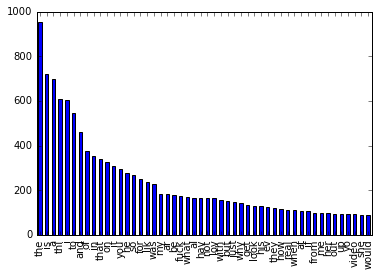

In [8]:
keyText = []
keyCount = []
for key, value in pt.indexedDictionary.items():
    c = pt.countInRecords([key])
    keyText.append(key)
    keyCount.append(c)
    
s1 = pa.Series(keyCount,index=keyText)

sortedS1  = s1.sort_values(ascending= False)[:50]

sortedS1.plot.bar()

In [9]:
df = pa.DataFrame(index=sortedS1.index, columns=sortedS1.index)
df = df.fillna(0)

In [10]:
names = sortedS1.index
colsdone = 0
for col in names:
    colsdone += 1
    sys.stdout.write("\rCols done : %i" % colsdone)
    for row in names:
        df[col][row] = pt.countInRecords([col,row])
sys.stdout.write("\n")
sys.stdout.flush()

Cols done : 50


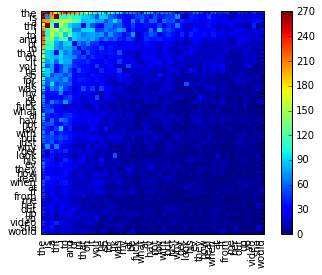

In [11]:
imgplot = plt.imshow(df,interpolation="nearest")
plt.xticks( range(len(names)), names, rotation=90 )
plt.yticks( range(len(names)), names, rotation=0 )
plt.colorbar()
plt.show()

In [12]:
myLabels = pa.Series(cleanedLabels)
myLabels.sum()

346.0

In [13]:
totalComments = myLabels.count()
totalTrollComments = myLabels.sum()
trollWeight = (totalComments-totalTrollComments)/totalComments
nonTrollWeight = totalTrollComments/totalComments

trollWeight, nonTrollWeight

(0.90020190366310937, 0.099798096336890685)

In [14]:
# for each troll comment add the troll weight to each word
# for each non troll comment minus the nonTrollWeight from each word

In [15]:
len(pt.cleanedDictionary)

3160

In [16]:
totalFoundTrolling = myLabels[pt.find(['the'])].sum()
totalFoundTrolling

61.0

In [17]:
totalFoundNotTrolling = pt.find(['the']).sum() - totalFoundTrolling
totalFoundNotTrolling

895.0

In [18]:
trollScore = (totalFoundTrolling * trollWeight) - (totalFoundNotTrolling * nonTrollWeight)
trollScore

-34.406980098067493

In [19]:
trollScores = []
for word in pt.cleanedDictionary:
    totalFoundTrolling = myLabels[pt.find([word])].sum()
    totalFoundNotTrolling = pt.find([word]).sum() - totalFoundTrolling
    trollScore = (totalFoundTrolling * trollWeight) - (totalFoundNotTrolling * nonTrollWeight)
    trollScores.append(trollScore)


the       -34.406980
i         -22.377848
to        -17.389963
it        -13.837612
lov       -12.366888
for       -12.248918
but       -12.069513
and       -11.206519
not        -9.466686
was        -7.753966
real       -7.376983
al         -6.566484
cut        -6.287280
so         -5.945486
know       -5.884050
on         -5.733776
happy      -5.688491
good       -5.684453
get        -5.572541
my         -5.562446
jam        -5.387078
when       -5.277185
do         -4.786271
he         -4.743871
best       -4.690511
in         -4.328526
pap        -4.191520
wil        -4.083646
me         -3.880012
we         -3.782232
             ...    
wher       -2.393135
very       -2.393135
nee        -2.389097
pretty     -2.295356
wait       -2.193539
thing      -2.193539
com        -2.187482
break      -2.095760
find       -2.095760
arian      -2.095760
dog        -2.095760
keep       -2.093741
org        -2.093741
that       -2.031151
our        -1.995962
respect    -1.995962
work       -1

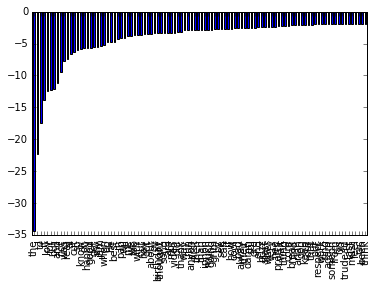

In [229]:
s2 = pa.Series(trollScores,index= pt.cleanedDictionary)

sortedPos  = s2.sort_values(ascending= True)[:100]

sortedPos.plot.bar()
print(sortedPos)

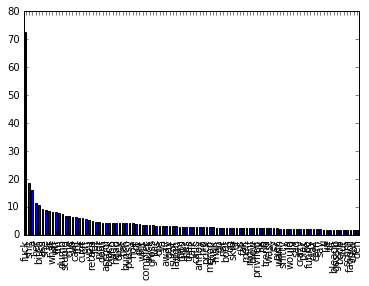

In [230]:
s2 = pa.Series(trollScores,index= pt.cleanedDictionary)

sortedNeg  = s2.sort_values(ascending= False)[:100]

sortedNeg.plot.bar()

3160

In [47]:
def calTrollScore(comment):
    words = str(comment).split(' ')
    score = 0
    for word in words:
        if word in s2:
            score += s2[word]
    return score

In [52]:
for i in range(10):
    print(cleanedRecords[i],calTrollScore(cleanedRecords[i]))

who els think act a gre sing 12.405537929
what a lucky got celebr birthday on concert with bil of cold fan 8.98240553793
lov it -26.2044995673
no am ev knew who cord was sev year ago -6.37179117393
my birthday was the as wel and we both support west ham -70.6758004038
org im cry -3.28526103259
i do feel cold ar extrem over howev thi was would lov to see mor stuff lik thi in the -87.7213729449
whoev post process that suck al the spirit of the perform but hey sound gre on yo -96.7923276608
i do lov u we r wait for u her in kiss -46.8543409288
the best duo i lov thi -67.9186616671


In [53]:
def predictTroll(comment,theta):
    return calTrollScore(comment) > theta[0]

def costTrollPredict(theta):
    result = list(map(lambda c:predictTroll(c,theta),cleanedRecords))

In [83]:
pred = costTrollPredict([30])
trueVal = list(map(lambda v: v==1.0,cleanedLabels))

In [75]:
from sklearn.metrics import f1_score

In [85]:
f1_score(trueVal, pred)

0.4140480591497227

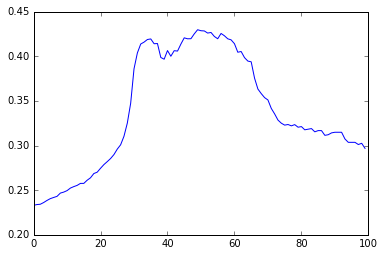

In [90]:
vals = []
for i in range(-30,70):
    predt = costTrollPredict([i])
    cost = f1_score(trueVal, predt)
    vals.append(cost)
plt.plot(vals)

In [93]:
np.asarray(costTrollPredict([50])).sum()

121

In [97]:
output = np.asarray(trueVal)

In [251]:
pred = np.asarray(costTrollPredict([0]))

In [252]:
output.sum()

346

In [253]:
len(pred)

3468

In [254]:
output[pred].sum()

252

In [104]:
pred

array([False, False, False, ..., False, False, False], dtype=bool)

In [272]:
def calculateEffect(predFunc):
    plotLog = []
    plotFalse = []
    plotx = []
    for i in range(-100,100,5):
        pred = np.asarray(predFunc([i]))
        trollsFound = output[pred].sum()
        falsePos = (output == False)[pred].sum()
        falsePosPc =  ((100/(output==False).sum())*falsePos)  
        plotLog.append((100/output.sum())*trollsFound)
        plotFalse.append(falsePosPc)
        plotx.append(i)
    return plotLog,plotFalse,plotx

[plotLog,plotFalse,plotx] = calculateEffect(costTrollPredict)

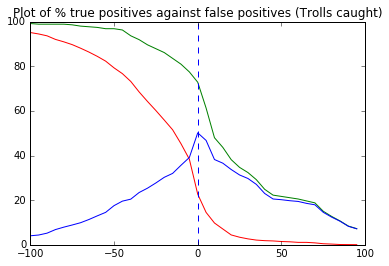

In [273]:
plotDiff = list(map(lambda a,b: a-b,plotLog,plotFalse ))
plt.title('Plot of % true positives against false positives (Trolls caught)')
plt.plot(plotx,plotLog,c='g')
plt.plot(plotx,plotFalse,c='r')
plt.plot(plotx,plotDiff,c='b')
plt.axvline(0,linestyle = 'dashed')

# Lower solution complexity for product implimentation
only calculate based on the top polarising negative words

In [312]:
usedNeg = sortedNeg[:20]
usedPos = sortedPos[:20]
def calTrollScoreSim(comment):
    words = str(comment).split(' ')
    score = 0
    for word in words:
        if word in usedNeg:
            score += usedNeg[word]
        elif word in usedPos:
            score += usedPos[word]
    return score

In [267]:
def predictTroll2(comment,theta):
    return calTrollScoreSim(comment) > theta[0]

def costTrollPredict2(theta):
    result = list(map(lambda c:predictTroll2(c,theta),cleanedRecords))
    return result

In [268]:
costTrollPredict2([0])

[True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 F

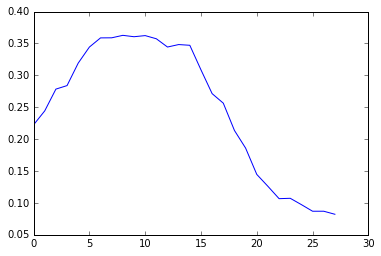

In [271]:
vals = []
for i in range(0,140,5):
    predt = costTrollPredict2([i])
    cost = f1_score(trueVal, predt)
    vals.append(cost)
plt.plot(vals)

In [301]:
[plotLog2,plotFalse2,plotx2] = calculateEffect(costTrollPredict2)

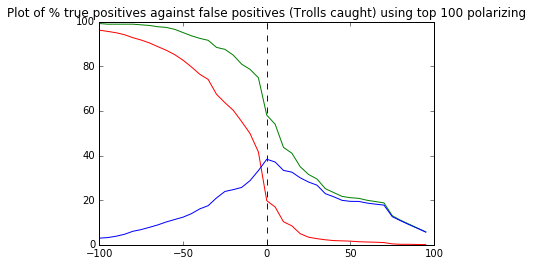

In [302]:
plotDiff2 = list(map(lambda a,b: a-b,plotLog2,plotFalse2 ))
plt.title('Plot of % true positives against false positives (Trolls caught) using top 100 polarizing')
plt.plot(plotx2,plotLog2,c='g')
plt.plot(plotx2,plotFalse2,c='r')
plt.plot(plotx2,plotDiff2,c='b')
plt.axvline(0,linestyle = 'dashed')

In [321]:
def calculateEffectAt0(predFunc):
    global usedNeg
    global usedPos
    plotLog = []
    plotFalse = []
    plotx = []
    for i in range(1,200,5):
        usedNeg = sortedNeg[:i]
        usedPos = sortedPos[:i]
        pred = np.asarray(predFunc([0]))
        trollsFound = output[pred].sum()
        falsePos = (output == False)[pred].sum()
        falsePosPc =  ((100/(output==False).sum())*falsePos)  
        plotLog.append((100/output.sum())*trollsFound)
        plotFalse.append(falsePosPc)
        plotx.append(i)
    return plotLog,plotFalse,plotx

In [322]:
[plotLog3,plotFalse3,plotx3] = calculateEffectAt0(costTrollPredict2)

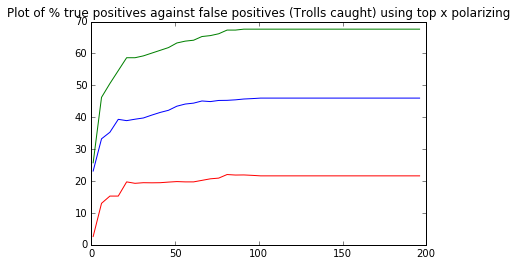

In [323]:
plotDiff3 = list(map(lambda a,b: a-b,plotLog3,plotFalse3 ))
plt.title('Plot of % true positives against false positives (Trolls caught) using top x polarizing')
plt.plot(plotx3,plotLog3,c='g')
plt.plot(plotx3,plotFalse3,c='r')
plt.plot(plotx3,plotDiff3,c='b')
plt.axvline(0,linestyle = 'dashed')